<a href="https://colab.research.google.com/github/khansaintania/2025_VISI_KOMPUTER_TI2B/blob/main/Jobsheet_03_TeknikRegresiGambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet 03: TEKNIK REGRESI GAMBAR

## Praktikum D1: Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y

    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)

    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)


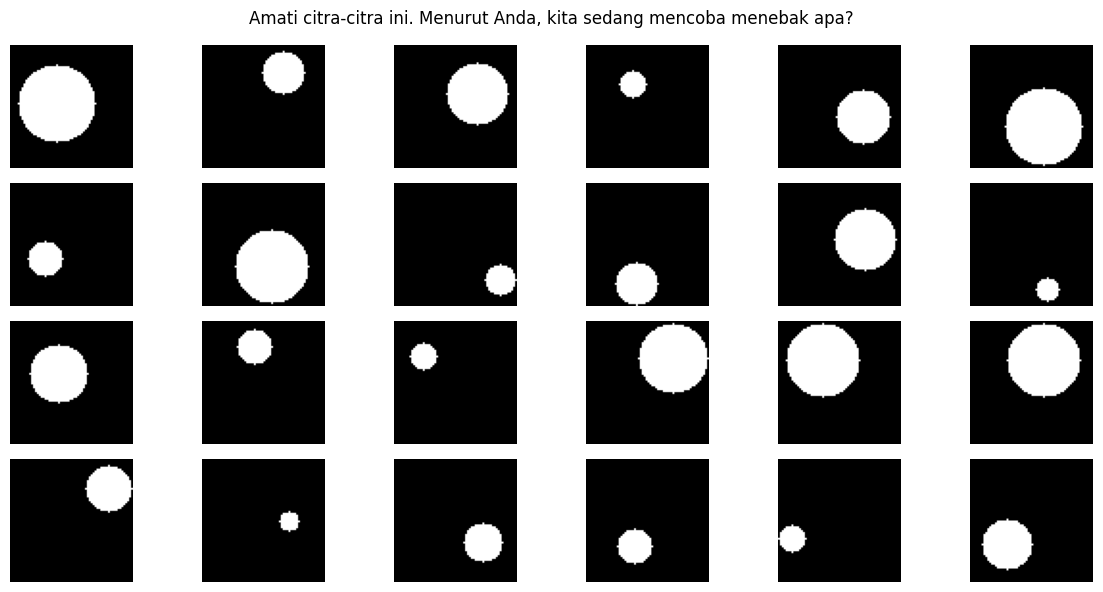

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


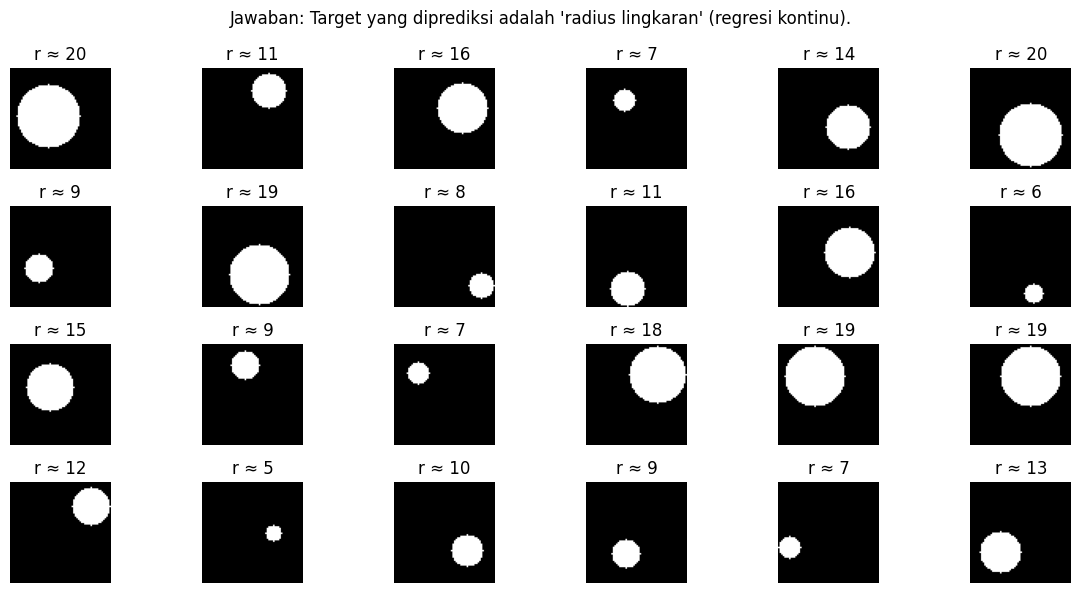

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MAE=0.968 | RMSE=1.225 | R²=0.928


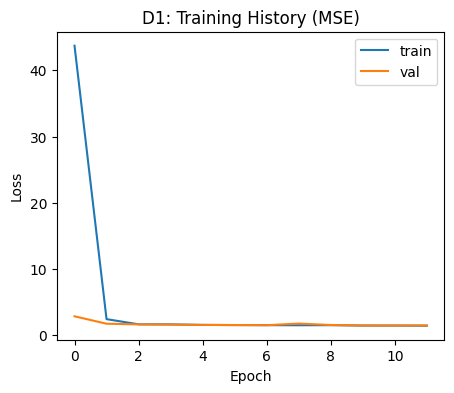

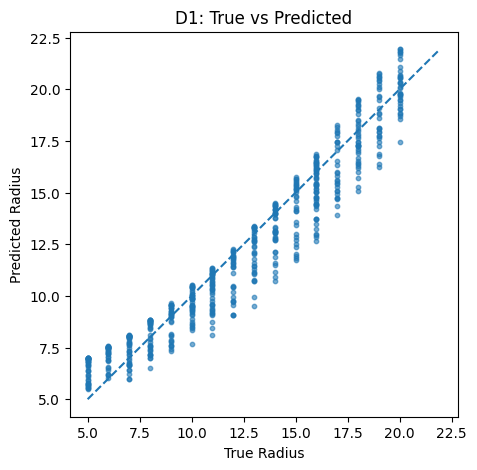

In [ ]:
# Plot loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


### Tantangan Mini D1

In [ ]:
# Fungsi baru: make_sample_varied()
def make_sample_varied(img_size=64, min_r=8, max_r=28, noise=False, blur=False):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)

    cv2.circle(img, (cx, cy), r, (255,), -1)

    # Tambahkan noise opsional
    if noise:
        noise_img = np.random.normal(0, 25, img.shape)  # noise Gaussian
        img = np.clip(img + noise_img, 0, 255)

    # Tambahkan blur opsional
    if blur:
        img = cv2.GaussianBlur(img, (5, 5), 0)

    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


In [ ]:
# Dataset baru dengan radius berbeda (8–28)
N = 3000
X_new, y_new, C_new = zip(*[make_sample_varied(noise=False, blur=False) for _ in range(N)])
X_new = np.array(X_new, dtype=np.float32)
y_new = np.array(y_new, dtype=np.float32)

# Split train-test baru
Xtr2, Xte2, ytr2, yte2 = train_test_split(X_new, y_new, test_size=0.2, random_state=42)


In [ ]:
# Gunakan arsitektur model yang sama, tapi latih ulang
model2 = models.clone_model(model)
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

history2 = model2.fit(
    Xtr2, ytr2,
    validation_data=(Xte2, yte2),
    epochs=12,
    batch_size=64,
    verbose=0
)


In [ ]:
# Evaluasi model baru
y_pred2 = model2.predict(Xte2).ravel()
mae2 = mean_absolute_error(yte2, y_pred2)
rmse2 = float(np.sqrt(np.mean((yte2 - y_pred2)**2)))
r2_2 = r2_score(yte2, y_pred2)

print("== Perbandingan Hasil ==")
print(f"Model Awal:      MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
print(f"Model Baru(8–28): MAE={mae2:.3f} | RMSE={rmse2:.3f} | R²={r2_2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
== Perbandingan Hasil ==
Model Awal:      MAE=0.968 | RMSE=1.225 | R²=0.928
Model Baru(8–28): MAE=0.775 | RMSE=0.978 | R²=0.974


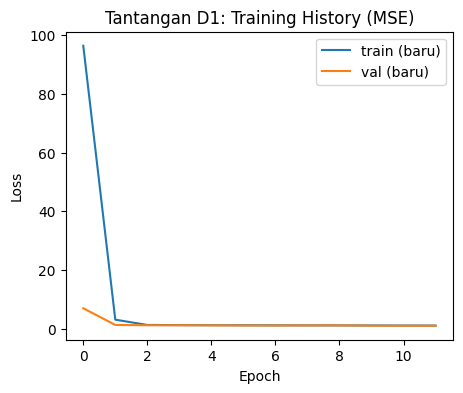

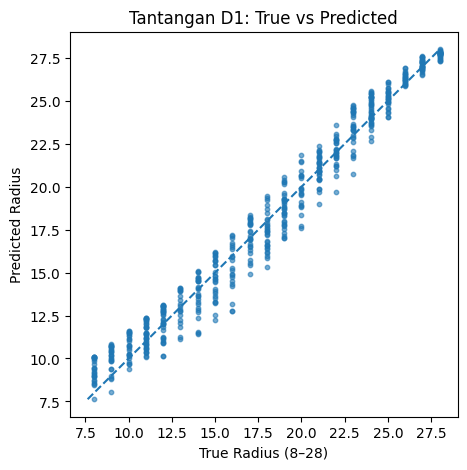

In [ ]:
# Plot training history baru
plt.figure(figsize=(5,4))
plt.plot(history2.history['loss'], label='train (baru)')
plt.plot(history2.history['val_loss'], label='val (baru)')
plt.title("Tantangan D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter plot prediksi vs nilai sebenarnya
plt.figure(figsize=(5,5))
plt.scatter(yte2, y_pred2, s=10, alpha=0.6)
lims = [min(yte2.min(), y_pred2.min()), max(yte2.max(), y_pred2.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius (8–28)")
plt.ylabel("Predicted Radius")
plt.title("Tantangan D1: True vs Predicted")
plt.show()


Multi-ouput

In [ ]:
# Fungsi untuk menghasilkan dataset dengan target multi-output [r, cx, cy]
import numpy as np # Import numpy here

def make_sample_multi(img_size=64, min_r=8, max_r=28):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, np.array([float(r), float(cx), float(cy)], dtype=np.float32)

# Membuat dataset baru
N = 3000
X_multi, y_multi = zip(*[make_sample_multi() for _ in range(N)])
X_multi = np.array(X_multi, dtype=np.float32)
y_multi = np.array(y_multi, dtype=np.float32)

# Split data
Xtr_m, Xte_m, ytr_m, yte_m = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)


In [ ]:
# Model CNN baru untuk prediksi [r, cx, cy]
model_m = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)  # output: [r, cx, cy]
])

model_m.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_m = model_m.fit(
    Xtr_m, ytr_m,
    validation_data=(Xte_m, yte_m),
    epochs=12,
    batch_size=64,
    verbose=0
)


In [ ]:
# Evaluasi model multi-output
y_pred_m = model_m.predict(Xte_m)

# Pisahkan tiap komponen agar mudah dianalisis
y_true_r, y_true_cx, y_true_cy = yte_m[:, 0], yte_m[:, 1], yte_m[:, 2]
y_pred_r, y_pred_cx, y_pred_cy = y_pred_m[:, 0], y_pred_m[:, 1], y_pred_m[:, 2]

# Hitung metrik evaluasi per komponen
mae_r = mean_absolute_error(y_true_r, y_pred_r)
mae_cx = mean_absolute_error(y_true_cx, y_pred_cx)
mae_cy = mean_absolute_error(y_true_cy, y_pred_cy)

rmse_r = np.sqrt(np.mean((y_true_r - y_pred_r)**2))
rmse_cx = np.sqrt(np.mean((y_true_cx - y_pred_cx)**2))
rmse_cy = np.sqrt(np.mean((y_true_cy - y_pred_cy)**2))

print("== Evaluasi Multi-output ==")
print(f"MAE_r = {mae_r:.3f}, RMSE_r = {rmse_r:.3f}")
print(f"MAE_cx = {mae_cx:.3f}, RMSE_cx = {rmse_cx:.3f}")
print(f"MAE_cy = {mae_cy:.3f}, RMSE_cy = {rmse_cy:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
== Evaluasi Multi-output ==
MAE_r = 1.067, RMSE_r = 1.344
MAE_cx = 3.703, RMSE_cx = 4.924
MAE_cy = 4.148, RMSE_cy = 5.400


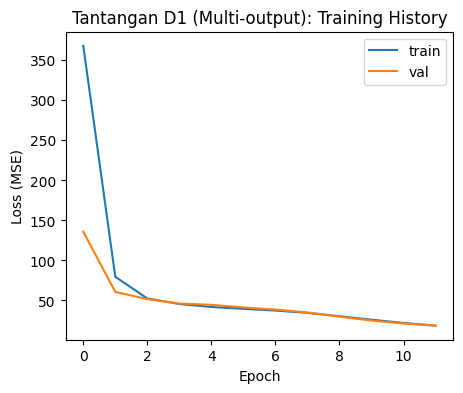

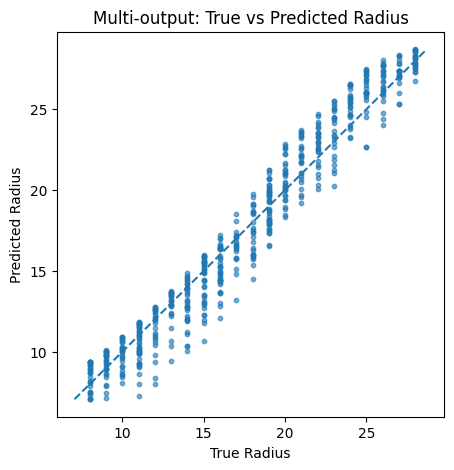

In [ ]:
# Plot training loss
plt.figure(figsize=(5,4))
plt.plot(history_m.history['loss'], label='train')
plt.plot(history_m.history['val_loss'], label='val')
plt.title("Tantangan D1 (Multi-output): Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Scatter plot untuk radius saja
plt.figure(figsize=(5,5))
plt.scatter(y_true_r, y_pred_r, s=10, alpha=0.6)
lims = [min(y_true_r.min(), y_pred_r.min()), max(y_true_r.max(), y_pred_r.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("Multi-output: True vs Predicted Radius")
plt.show()


## Praktikum D2: Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khansaintaniautomo","key":"3a8c045eddeb0c172be92b83d754bf71"}'}

In [2]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("  kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


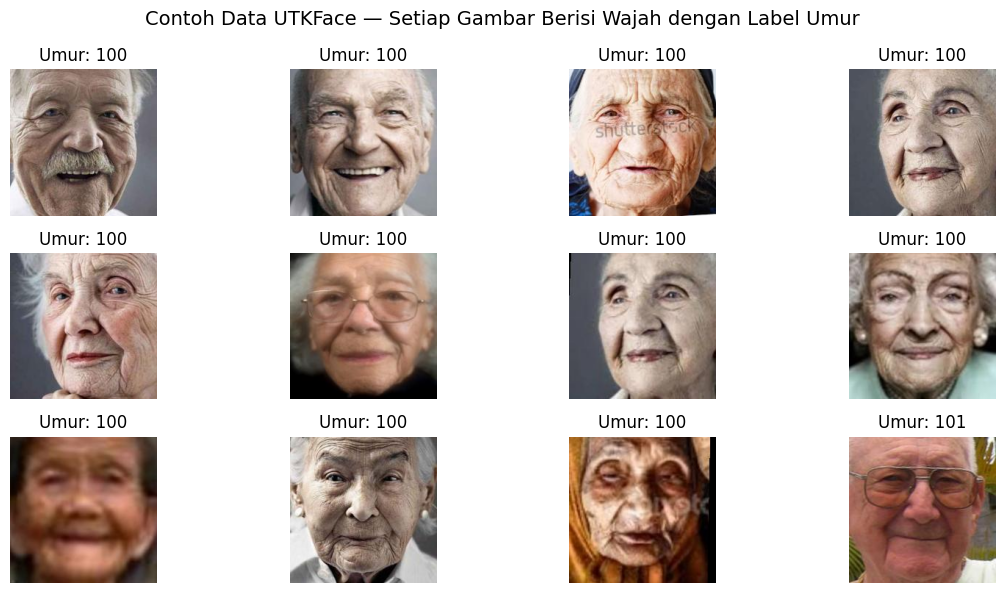

In [4]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


In [13]:
# ---- Tantangan Mini ----
from tensorflow.keras import layers

# Tambahkan augmentasi ekstra: brightness, kontras, dan zoom
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2),
])

# Terapkan augmentasi ke dataset training
aug_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Ulangi batch agar tetap konsisten
aug_train_ds = aug_train_ds.prefetch(tf.data.AUTOTUNE)
print("✅ Dataset training dengan augmentasi siap digunakan.")


✅ Dataset training dengan augmentasi siap digunakan.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# ---- Tantangan Mini ----
from tensorflow.keras.optimizers import AdamW

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='mse',
    metrics=['mae']
)

print("✅ Model dikompilasi ulang dengan AdamW.")


✅ Model dikompilasi ulang dengan AdamW.


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()


Hardware: CPU


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - loss: 504.2223 - mae: 17.0808 - val_loss: 316.5534 - val_mae: 14.5562 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - loss: 397.4109 - mae: 15.2913 - val_loss: 264.0219 - val_mae: 11.8371 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - loss: 394.0576 - mae: 15.2266 - val_loss: 224.7623 - val_mae: 11.5739 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - loss: 393.0109 - mae: 15.1791 - val_loss: 245.8775 - val_mae: 12.7050 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - loss: 391.1714 - mae: 15.1116 - val_loss: 254.2264 - val_mae: 13.0221 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - loss: 390.5171 - mae: 15.1526 - val_loss: 240.6238 - val_mae: 12.5250 - learning_rate: 5.0000e-04


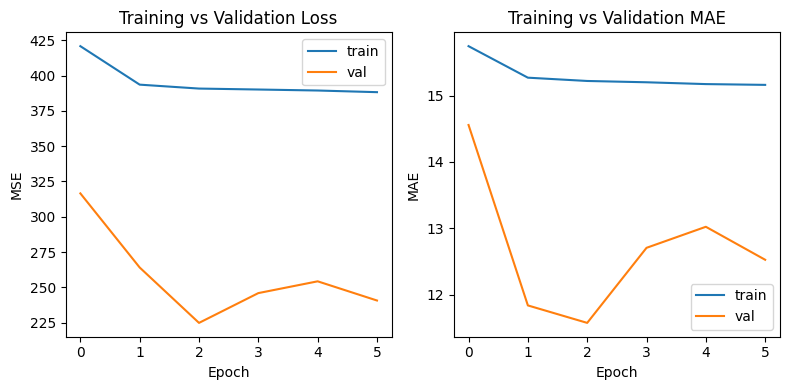

In [18]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    aug_train_ds, # diganti dengan aug_train_ds untuk tantangan mini
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - loss: 410.3245 - mae: 15.5263 - val_loss: 132.9914 - val_mae: 8.3407 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 791s 3s/step - loss: 384.6306 - mae: 15.1072 - val_loss: 124.2396 - val_mae: 8.1708 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - loss: 369.6885 - mae: 14.7588 - val_loss: 125.5095 - val_mae: 8.1369 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 843s 3s/step - loss: 366.3660 - mae: 14.7038 - val_loss: 122.4328 - val_mae: 8.2008 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 815s 3s/step - loss: 357.2426 - mae: 14.5729 - val_loss: 144.0217 - val_mae: 8.7258 - learning_rate: 1.0000e-04


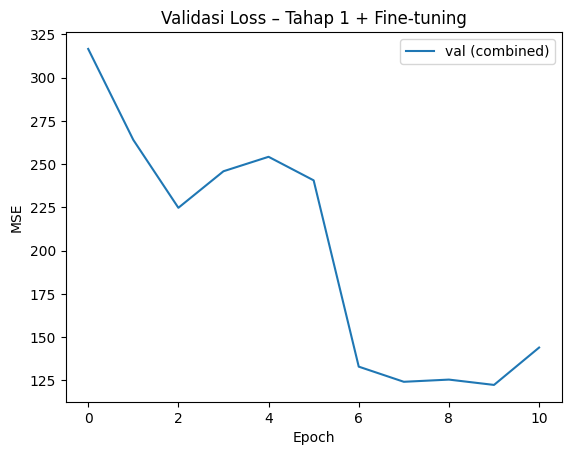

In [27]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history_ft = model.fit(
    aug_train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE  = 8.20 tahun
RMSE = 11.06 tahun
R²   = 0.692


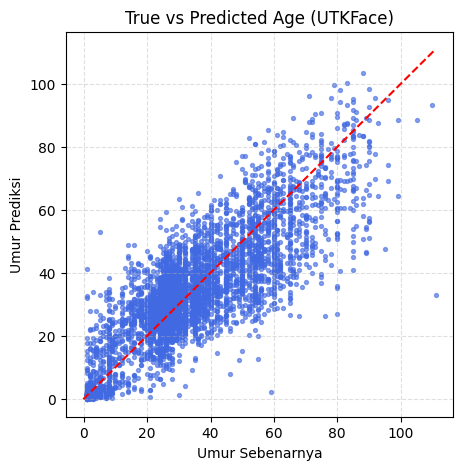

In [28]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae  = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2   = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


/tmp/ipython-input-4226115402.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mae = df_eval.groupby('group').apply(lambda x: mean_absolute_error(x['true_age'], x['pred_age']))
/tmp/ipython-input-4226115402.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_mae = df_eval.groupby('group').apply(lambda x: mean_absolute_error(x['true_age'], x['pred_age']))


MAE per kelompok umur:
group
0–10      4.473527
11–20    10.141673
21–30     6.463952
31–40     7.018486
41–50     9.429381
51–60    12.163629
61–70    13.375691
71–80    14.437256
81+      16.919157
dtype: float64


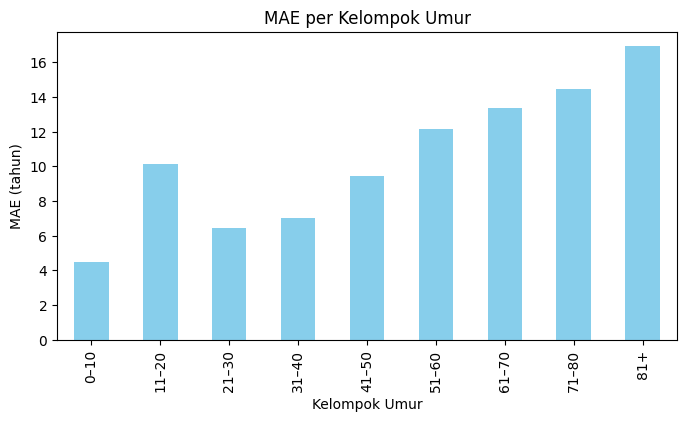

In [29]:
# ---- Tantangan Mini ----
import pandas as pd

# Buat dataframe hasil prediksi
df_eval = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_pred
})

# Kelompok umur
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['0–10', '11–20', '21–30', '31–40', '41–50', '51–60', '61–70', '71–80', '81+']
df_eval['group'] = pd.cut(df_eval['true_age'], bins=bins, labels=labels, right=True)

# Hitung MAE per kelompok
group_mae = df_eval.groupby('group').apply(lambda x: mean_absolute_error(x['true_age'], x['pred_age']))
print("MAE per kelompok umur:")
print(group_mae)

plt.figure(figsize=(8,4))
group_mae.plot(kind='bar', color='skyblue')
plt.title("MAE per Kelompok Umur")
plt.ylabel("MAE (tahun)")
plt.xlabel("Kelompok Umur")
plt.show()


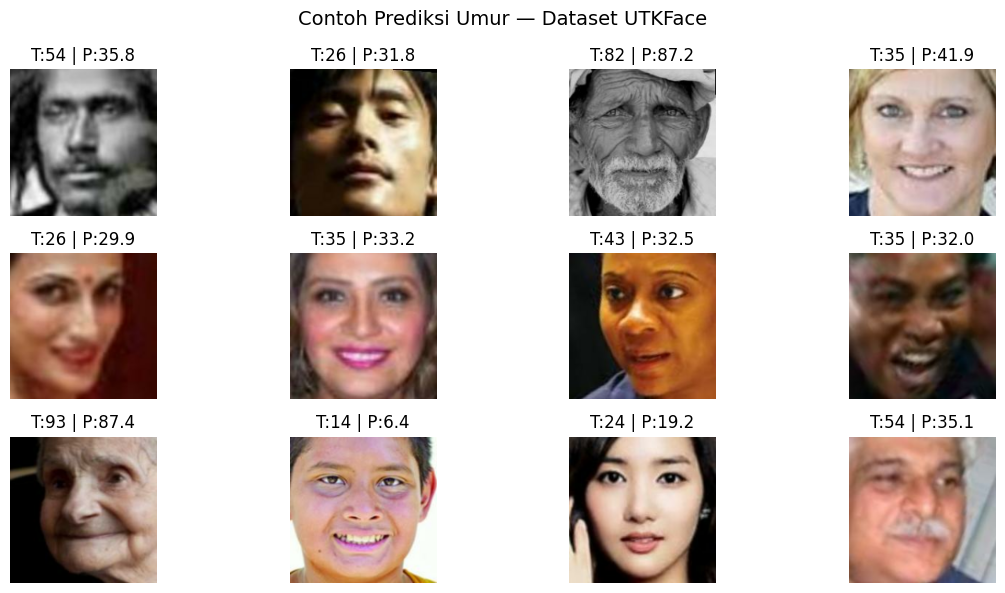

In [30]:
import random

sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Saving fotopercobaan.jpg to fotopercobaan (1).jpg


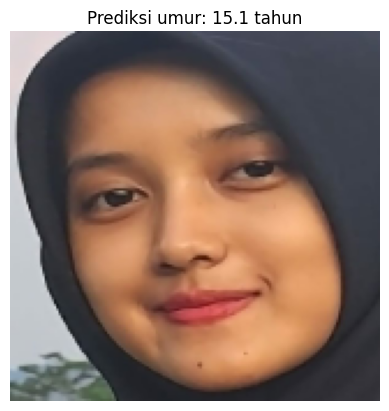

In [35]:
# ---- Tantangan Mini ----
from PIL import Image

# Upload foto wajah sendiri
from google.colab import files
uploaded = files.upload()

# Ganti nama file di sini
img_path = list(uploaded.keys())[0]

# Load dan resize gambar
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

# Prediksi umur
pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

plt.imshow(img.numpy())
plt.title(f"Prediksi umur: {pred_age:.1f} tahun")
plt.axis('off')
plt.show()


## Praktikum D3: Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [2]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("  kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

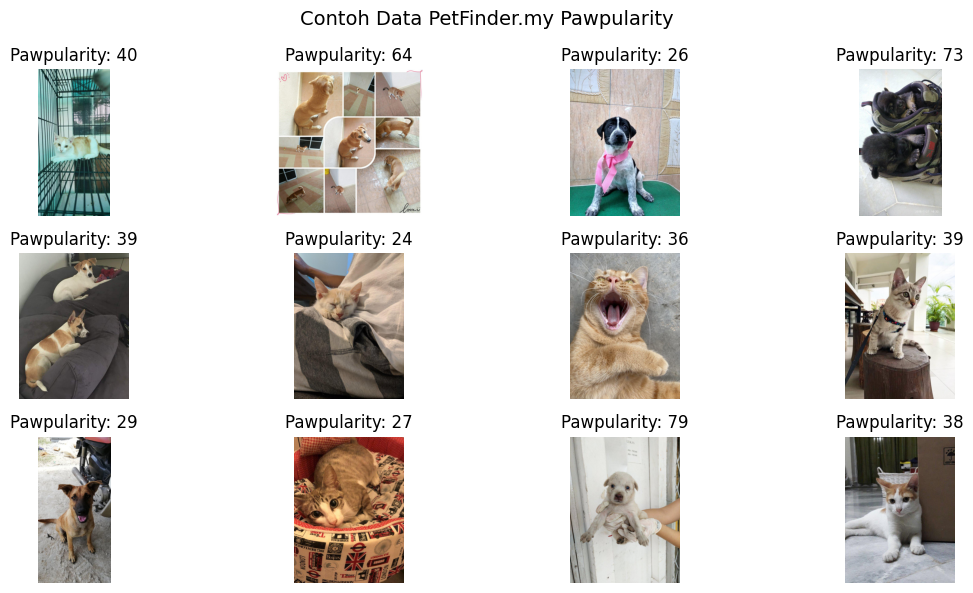

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

from tensorflow.keras import layers

# Data augmentation agar model tidak bosan dengan pola yang sama
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(factor=0.2),
])

def load_image_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    img = data_augmentation(img)
    return img, tf.cast(label, tf.float32)

# Dataset dengan augmentasi untuk training
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

# Validation tanpa augmentasi
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# --- Model alternatif: EfficientNetB3 ---
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_b3.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,264 (42.64 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [8]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)
]

history_b0 = model.fit(
    train_ds.take(30),
    validation_data=val_ds.take(10),
    epochs=3,
    callbacks=cb,
    verbose=1
)

history_b3 = model_b3.fit(
    train_ds.take(30),
    validation_data=val_ds.take(10),
    epochs=3,
    callbacks=cb,
    verbose=1
)


Epoch 1/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 362s 9s/step - loss: 373675.7500 - mae: 186.0838 - val_loss: 1886.2162 - val_mae: 38.2354
Epoch 2/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 319s 8s/step - loss: 80347.4141 - mae: 99.9651 - val_loss: 1885.5769 - val_mae: 38.2301
Epoch 3/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - loss: 13289.5674 - mae: 58.9971 - val_loss: 1879.1194 - val_mae: 38.1453
Epoch 1/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 524s 14s/step - loss: 82175968.0000 - mae: 2925.2385 - val_loss: 1887.9856 - val_mae: 38.2645
Epoch 2/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 560s 14s/step - loss: 13584644.0000 - mae: 1359.2065 - val_loss: 1883.5676 - val_mae: 38.2046
Epoch 3/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 557s 16s/step - loss: 4075284.5000 - mae: 728.5421 - val_loss: 1878.8887 - val_mae: 38.1444


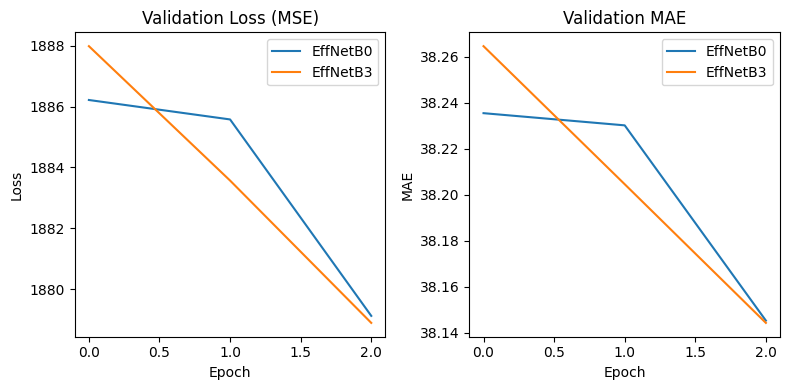

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_b0.history['val_loss'], label='EffNetB0')
plt.plot(history_b3.history['val_loss'], label='EffNetB3')
plt.title("Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_b0.history['val_mae'], label='EffNetB0')
plt.plot(history_b3.history['val_mae'], label='EffNetB3')
plt.title("Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

def evaluate_model(model, val_df, val_ds, name):
    y_true = val_df['Pawpularity'].values.astype(np.float32)
    y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(np.mean((y_true - y_pred)**2))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")
    return mae, rmse, r2

evaluate_model(model, val_df, val_ds, "EfficientNetB0")
evaluate_model(model_b3, val_df, val_ds, "EfficientNetB3")
# evaluate_model(model_resnet, val_df, val_ds, "ResNet50")


EfficientNetB0: MAE=38.03 | RMSE=43.45 | R²=-3.271
EfficientNetB3: MAE=38.02 | RMSE=43.44 | R²=-3.269


(38.02104568481445, 43.43949101776876, -3.2688612937927246)

In [15]:
# Versi B: otomatis deteksi dog vs cat dengan MobileNetV2 (heuristik)
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
from PIL import Image

imagenet_clf = MobileNetV2(weights='imagenet')

def predict_imagenet_label(path):
    # load & preprocess
    img = Image.open(path).convert('RGB').resize((224,224))
    arr = np.array(img).astype(np.float32)
    arr = preprocess_input(arr)  # mobilenet preprocessing
    arr = np.expand_dims(arr, 0)
    preds = imagenet_clf.predict(arr)
    decoded = decode_predictions(preds, top=3)[0]  # list of (class, name, prob)
    names = [d[1] for d in decoded]  # human readable names
    return names, decoded

# Heuristik sederhana: kalau salah satu nama mengandung 'cat' atau 'kitten' => cat;
# kalau mengandung 'dog' atau banyak breed keywords => dog.
dog_keywords = set([
    'dog','hound','retriever','terrier','sheepdog','shih-tzu','pug','beagle','maltese',
    'wolfhound','chihuahua','doberman','husky','golden_retriever','labrador'
])
cat_keywords = set(['cat','kitten','tabby','Persian','Siamese','Egyptian_cat','tiger_cat','lynx'])

def auto_label_dog_cat(path):
    names, decoded = predict_imagenet_label(path)
    joined = " ".join(names).lower()
    # check cat
    for kw in cat_keywords:
        if kw.lower() in joined:
            return 'cat'
    # check dog
    for kw in dog_keywords:
        if kw.lower() in joined:
            return 'dog'
    # fallback: pick top-1 and check if it contains 'cat' or common dog breed words
    top1 = names[0].lower()
    if 'cat' in top1 or 'kitten' in top1:
        return 'cat'
    # many dog breeds don't have 'dog' word, but we assume breed names (like 'golden_retriever') -> dog
    # fallback use presence of common dog substrings
    for kw in ['retriever','terrier','spaniel','bulldog','shepherd','husky','pomeranian','pug','beagle']:
        if kw in top1:
            return 'dog'
    # if unsure:
    return 'unknown'

# Apply (lambat jika banyak gambar) — lakukan hanya pada val_df untuk cepat
val_df = val_df.copy()
val_df['pred_species'] = val_df['path'].apply(auto_label_dog_cat)

# Lihat distribusi
print(val_df['pred_species'].value_counts())

# Pisahkan
dogs_val = val_df[val_df['pred_species'] == 'dog']
cats_val = val_df[val_df['pred_species'] == 'cat']

# Evaluasi (gunakan model yang sudah kamu pilih, misal model_b3)
from sklearn.metrics import mean_absolute_error
def evaluate_subset_auto(model, subset_df, name):
    ds = tf.data.Dataset.from_tensor_slices((subset_df['path'], subset_df['Pawpularity'])) \
        .map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)
    y_true = subset_df['Pawpularity'].values
    y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in ds])
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name}: n={len(subset_df)} | MAE={mae:.2f}")
    return mae

print("=== Evaluasi (auto-labeled) pada Validation Set per Spesies ===")
mae_dog = evaluate_subset_auto(model_b3, dogs_val, "Dog (auto)")
mae_cat = evaluate_subset_auto(model_b3, cats_val, "Cat (auto)")

if mae_dog < mae_cat:
    print("\nKesimpulan: model lebih akurat pada anjing (MAE lebih rendah).")
elif mae_cat < mae_dog:
    print("\nKesimpulan: model lebih akurat pada kucing (MAE lebih rendah).")
else:
    print("\nKesimpulan: akurasi mirip untuk kedua spesies.")


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

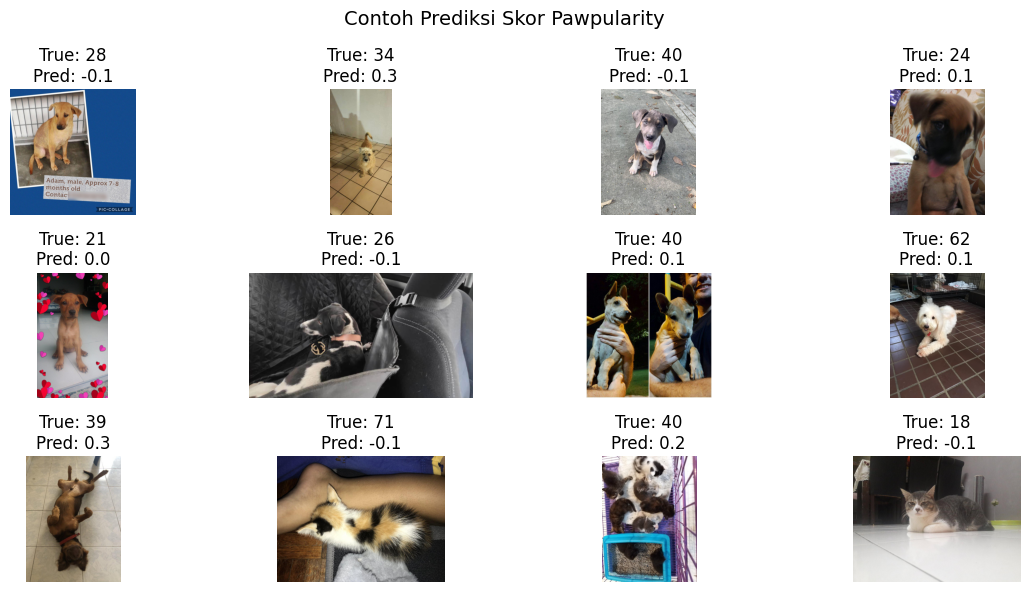

In [11]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
# --- Hitung brightness rata-rata per gambar ---
def get_brightness(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    brightness = tf.reduce_mean(tf.image.rgb_to_grayscale(img))
    return brightness.numpy()

df['brightness'] = df['path'].apply(get_brightness)

# --- Model gabungan visual + brightness ---
base = tf.keras.applications.EfficientNetB3(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet'
)
base.trainable = False

visual_input = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(visual_input * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

numeric_input = tf.keras.Input((1,))
concat = layers.Concatenate()([x, numeric_input])

x = layers.Dense(128, activation='relu')(concat)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1)(x)

model_combined = tf.keras.Model([visual_input, numeric_input], output)
model_combined.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_combined.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ multiply_2[0][0]  │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1537)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,980,528 (41.89 MB)

 Trainable params: 196,993 (769.50 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [14]:
print(df.columns)
df.head()


Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',
       'path', 'brightness'],
      dtype='object')


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,brightness
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/paw/train/0007de18844b0dbbb5e1f607da0...,0.584888
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/paw/train/0009c66b9439883ba2750fb825e...,0.373562
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/paw/train/0013fd999caf9a3efe1352ca1b0...,0.458573
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/paw/train/0018df346ac9c1d8413cfcc888c...,0.613553
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/paw/train/001dc955e10590d3ca4673f034f...,0.505162
